In [13]:
import agent
from importlib import reload
reload(agent)

<module 'agent' from '/Users/nagajas/Desktop/rl_trader_AI/agent.py'>

Model already trained.
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Test size:  2123
Mean Squared Error:  0.8734190682223406


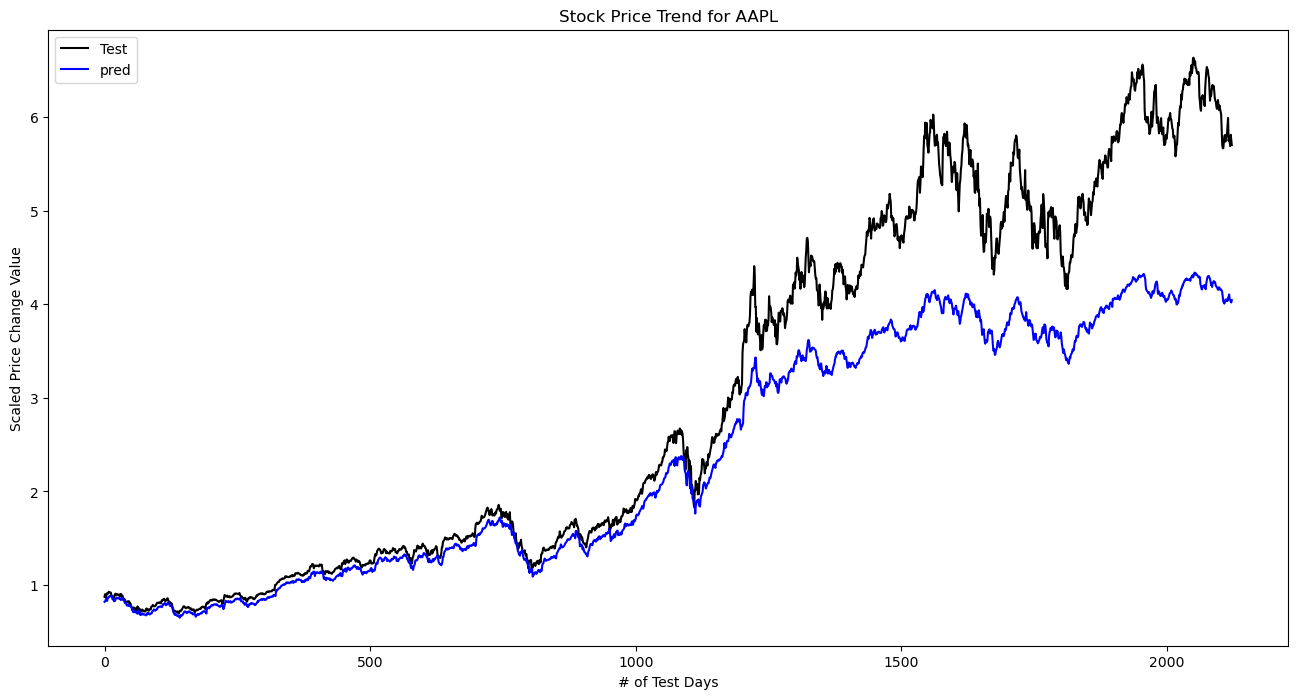

0.8734190682223406

In [14]:
agent = agent.TradeAgent('AAPL', 30, 8)
agent.train(32,30)
agent.save_model()
agent.evaluate()